# MHPC Deep Learning Course Assignment

# The Lottery Ticket Hypothesis

The aim of this exercise is to explore a somewhat misterious property of deep neural networks 
(DNN), i.e. the existence of very small subnetworks S of a given network N that are *trainable* 
and can reach the same performance of N (or even higher). 

This intriguing observation has been elevated to the rank of an **hypothesis** in the seminal work by Frankle & Carbin [3]

https://arxiv.org/abs/1803.03635

*Any large network that trains successfully contains a subnetwork that is initialized such that - when trained in isolation - it can match the accuracy of the original network in at most the same number of training iterations*

The authors metaphorically called this subnetwork as a *winning ticket*.

In some cases these subnetworks are really small. We can find subnetworks with the  $\approx 1 \%$ or less of the original connections.

Imagine the possible applications of such tiny DNNs. Being small means less memory and less computation required: this can be crucial in developing embedded systems that, given a target performance to be reached, can afford it with lower resources, including energy consumption.

From a theoretical viewpoint there is also another interesting angle. If these subnetworks are so small then, shall we think differently about the problem of *overparametrization*?

Let us state it more clearly. A very diffuse concern about DNNs is the fact that the number of parameters is often vastly larger then the number of data points. For example we will work in this notebook with a network with $\approx 400,000$ *trainable* parameters on the MNIST dataset, that has 60,000 training samples. This means that on average we have 7 parameters for each data point.
If we compare this situation with polynomial regression of a dataset of 10 points, for example, a polynomial of degree 10 (that has 11 parameters) overfits the data perfectly. But in DNNs overfitting - while still there - is not as severe as we could expect.

But now, if we can reduce by two orders of magnitude the number of parameters in DNNs, does this concern still hold?
We don't know the answer, and that's *one* of the reasons why we are here.

We are PyTorch beginners, but what we saw in the course is enough to approach this *research* problem in DNNs, from an empirical viewpoint. Hopefully, this will give you stimuli to explore more in depth these problems, adding your perspective to it.

Another point of this exercise is to make experience of *new strategies in research and knowledge dissemination*. 
Short communications - going straight to the point - are very effective indeed as a *first* exposition to a new subject. 

### Evaluation

In order to pass the exam you should work on some mandatory assignments.
These are:

- reading assignments
- brief answers to the questions in the notebook
- completion of the PyTorch code in this notebook

If you want to receive full grades

- do all the optional exercises in PyTorch (there are two)

The optional assignments will be marked with 'OPTIONAL' in the following.

# Reading assignment

The first part of this exercise is a mandatory *reading assignment*.

You should read


- the original paper
https://arxiv.org/abs/1905.01067

- the research account from the Uber Engineering AI team's blog:
https://eng.uber.com/deconstructing-lottery-tickets/


We suggest if you want to go deeper in this, to read also the original reference

https://arxiv.org/abs/1803.03635

After the readings, we will try to reproduce one of their numerous experiments. Take your time for this and enjoy your reading!


![](./figs_nb/manuscript.jpg)

# After the readings

Once we are confident with the ideas in the original paper

https://arxiv.org/abs/1905.01067

we will take it as a reference, and intertwin some excerpts from the original text and some of its figures 
with code and exercises.

You may parallel now the reading of the notebook with the paper.

### Introduction 


[...] A recent work by Frankle & Carbin [3] was thus surprising to many researchers when it presented
a simple algorithm for finding sparse subnetworks within larger networks that are trainable[...] 

Here the key word is *trainable*: it is possible to find sparse subnetworks that perform well but they are difficult 
to train directly from scratch.


You may want (OPTIONAL) to check the research described in the original paper

https://arxiv.org/abs/1803.03635


and a video presentation (OPTIONAL) of the original research at ICLR conference 2019

https://www.youtube.com/watch?v=s7DqRZVvRiQ&t=3s


Briefly, their approach for finding these sparse, performant networks is as follows: 

- train a network
- set all weights smaller than some threshold (in absolute value) to zero
- prune them
- rewind the rest of the weights to their initial configuration
- retrain the network from this starting configuration but with the zero weights frozen (not trained)


Using this approach, they obtained two intriguing results

- the pruned networks performed well
- the network trains well only if it is rewound to its initial state

**The Lottery Ticket Algorithm**

[...]We begin by briefly describing the lottery ticket algorithm (we simplify things a bit with respect
to the paper):

- Initialize a mask m to all ones (in the PyTorch code this will be a list of tensors of the same shapes of the ones given by model.parameters()). 

- Randomly initialize the parameters w of a network
$f(x;w \star m)$ ($\star$ stands for elementwise multiplication), in this case of course the multiplication by the mask does not have any effect.

- Train the parameters w of the network $f(x;w \star m)$ to completion. Denote the initial weights
before training wi and the final weights after training wf

- Mask Criterion. Use the mask criterion $M(wi; wf)$ to produce a masking score for each
currently unmasked weight. 

Method to create the mask: 


<span style="color:red">
Rank the weights in each layer by their scores, set the mask
value for the top $p\%$ to 1, the bottom $(100 - p)\%$ to 0. 
The mask selected weights with large final value corresponding to $M(wi;wf) = |wf|$.
</span>   


This text is colored in red because this is what is done in the paper, but we will do it *differently*, as we will explain below!

3. Mask-1 Action. Take some action with the weights with mask value 1. In [3] these weights
were reset to their initial values and marked for training in the next round.

4. Mask-0 Action. Take some action with the weights with mask value 0. In [3] these weights
were pruned: set to 0 and frozen during any subsequent training [...]


We do not consider iterative pruning (as in the original paper by Frankle and Carbin too): we do it just once.

Other masking criteria are possible:


![](./figs_nb/mask_criteria.png)

we will stick for the moment with the original one, which is the large final (LF) mask.


We will do experiments on a small convolutional network trained on the MNIST dataset.

### Imports

Here we start with the necessary imports for the PyTorch version.

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
from torchsummary import summary
import os
from os.path import join
import math

### Exercise 1: the Network

Define the network with a class Net as we already did (check conv.py on day2 for example).

To check your architecture is correct you should see something like this when printing the model:
    
    model = Net().to(device)
    print(model)

    Net(
    (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=800, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=10, bias=True)
    )


    and summary() should give something like this 

    summary(model, (1,28,28))
    
    ----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    ================================================================
                Conv2d-1           [-1, 20, 24, 24]             520
                Conv2d-2             [-1, 50, 8, 8]          25,050
                Linear-3                  [-1, 500]         400,500
                Linear-4                   [-1, 10]           5,010
    ================================================================
    Total params: 431,080
    Trainable params: 431,080
    Non-trainable params: 0
    ----------------------------------------------------------------
    Input size (MB): 0.00
    Forward/backward pass size (MB): 0.12
    Params size (MB): 1.64
    Estimated Total Size (MB): 1.76
    ----------------------------------------------------------------

In [2]:
# copied from day2/3_extraction_cnn.ipynb
class Net(nn.Module):
    #define the building blocks that i need:
    def __init__(self):
        super(Net, self).__init__()
        #convolutional layers for 1 channel, 20 filters of size 5x5:
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # keep last parameter =1
        
        #another convolutional layer with an input of 20 channels 
        #(20 versions of the image given by the 20 filter)
        # this convolutiona layer has 50 filters of size 5x5:
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        
        # 500 is the width of the last hidden layer
        self.fc1 = nn.Linear(4*4*50, 500)
        # transformation from the size of the last
        # hidden layer to the output
        self.fc2 = nn.Linear(500, 10)

    # describe the flow of information inside the network:
    def forward(self, x):
        # do a convulution and apply the relu :
        x = F.relu(self.conv1(x))
        # take the max value of the maps  reducing the 
        # representation by a factor of 2x2=4 :
        x = F.max_pool2d(x, 2, 2)
        # again, do a convulution and apply the relu :
        x = F.relu(self.conv2(x))
        # further reducing the dimensionality of the reppresentation :
        x = F.max_pool2d(x, 2, 2)
        # for each datapoint a want one vector of length 4*4*50 :
        x = x.view(-1, 4*4*50)
        # flatten it into a single vector : 
        x = F.relu(self.fc1(x))
        # perform the last linear transformation applying the last
        # non-linearity :
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

##### Check your Net

In [3]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

model = Net()
model = Net().to(device)
print(model)
print(summary(model, (1,28,28)))
print('\nUsing',device,'device')


Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                   [-1, 10]           5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.76
----------------------------------------------------------------
None

Using cpu device


### Exercise 2: Training and test functions

Before implementing the LT algorithm there are two changes we have to make to the *standard* 
training functions (as used for example in conv.py of day2)

- add an optional argument *mask*
- write the code that, if a mask is passed, modifies the update in order to freeze the parameters whose mask value is zero

Notice that in PyTorch we can set the flag require_grad to *tensors*, but not to their individual elements. Let us recall this once.

For tensors we could proceed as follows (we did something like this in the transfer learning, when we froze all the network but the last hidden layer):

In [4]:
# show the requires_grad flags
for p in model.parameters():
    print(p.shape, p.requires_grad)

torch.Size([20, 1, 5, 5]) True
torch.Size([20]) True
torch.Size([50, 20, 5, 5]) True
torch.Size([50]) True
torch.Size([500, 800]) True
torch.Size([500]) True
torch.Size([10, 500]) True
torch.Size([10]) True


In [5]:
# freeze first hidden layer as an example
list(model.parameters())[0].requires_grad=False

In [6]:
# check that the flag has changed
for p in model.parameters():
    print(p.requires_grad)

False
True
True
True
True
True
True
True


Let us re-set to True the flag we changed.

In [7]:
list(model.parameters())[0].requires_grad=True

But in order to *freeze* individual elements of our parameter tensors we have to proceed differently:

- compute the gradient with respect to all the parameters 
- set to zero the gradients of the parameters whose mask value is zero
- do the normal update


Complete the code in the following cell:

In [8]:
log_interval=187
def train(model, device, train_loader, optimizer, epoch, mask=None):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # Zero the gradients before computing the loss fction
        optimizer.zero_grad()
        output = model(data)
        #Define a loss function
        loss = F.nll_loss(output, target)
        
        
        #----------- compute the gradients -----------------------------------------
        # compute the gradient with respect to all the parameters
        loss.backward()
        #----------- zero the gradients ---------------------------------------------
        if(mask):
            # set to zero the gradients of the freezed parameters if a mask is passed as a parameter
            for m,p in zip(mask,model.parameters()):
                #for m,p in zip(masklist,paramlist):
                p.grad.mul_(m)
                
        #------------ parameters update ---------------------------------------
        optimizer.step()

        #if batch_idx % log_interval == 0:
        #    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, batch_idx * len(data), len(train_loader.dataset),
        #        100. * batch_idx / len(train_loader), loss.item()))
        #----------------------------------------------------------------------------------------------

The test function is left unchanged

In [9]:
def test(model, device, test_loader,verbose=False):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    
    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            loss, correct, len(test_loader.dataset), acc))
    return acc

Now we are ready to do the experiment with the LF mask.
Before doing that we have to 

- set our hyperparameters
- deal with the data

Just evaluate the following two cells.

# Hyperparameters settings

In [10]:
batch_size=64

#number of epochs 
epochs=5

#learning rate
lr=0.01

# keep the momentum to 0, otherwise also freezed parameters 
# will move for the momentum contribution to parameters evolution
momentum=0.0

seed=1
torch.manual_seed(seed)
save_model=1

# Data

In [11]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# Exercise 3: First Training

During the first training you will

- initialize the network and send to device
- store the initial weights (wi) of the network
- init the optimizer
- train the network without any mask (or passing a mask of ones if you prefer)
- store the final weights (wf)

The final weights will be used later to compute the LF mask.

During the training check that your loss is getting smaller and your accuracy on test set higher.

In [12]:
# initialize the network and send to device:
model = Net().to(device)
if not os.path.isdir('./models'):
    os.mkdir('./models')
# store the initial weights (wi) of the network :
torch.save(model.state_dict(), 'models/initial.pt')

In [13]:
# init the optimizer:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [14]:
test(model, device, test_loader,verbose=True)
for epoch in tqdm(range(1, epochs + 1)):
    train(model,device,train_loader,optimizer,epoch,mask=None)
    test(model, device, test_loader,verbose=True)
    
if (save_model):
    print('Saving model.')
    # store the new weights (wi) of the network :
    torch.save(model.state_dict(), 'models/trained_without_mask.pt')

  0%|          | 0/5 [00:00<?, ?it/s]


Test set: Average loss: 2.3022, Accuracy: 933/10000 (9.33%)



 20%|██        | 1/5 [00:22<01:28, 22.04s/it]


Test set: Average loss: 0.1769, Accuracy: 9458/10000 (94.58%)



 40%|████      | 2/5 [00:45<01:07, 22.52s/it]


Test set: Average loss: 0.1036, Accuracy: 9697/10000 (96.97%)



 60%|██████    | 3/5 [01:12<00:47, 23.81s/it]


Test set: Average loss: 0.0673, Accuracy: 9803/10000 (98.03%)



 80%|████████  | 4/5 [01:37<00:24, 24.25s/it]


Test set: Average loss: 0.0608, Accuracy: 9809/10000 (98.09%)



100%|██████████| 5/5 [02:01<00:00, 24.35s/it]


Test set: Average loss: 0.0628, Accuracy: 9794/10000 (97.94%)

Saving model.


### Masks

We define different masks.

- the identity mask, which is useful for debugging: it will left the training unaltered
- the random mask, that we will use to make comparisons
- the LF (large final) mask

The first two are given, the implementation of the LF mask is an exercise.

In [15]:
def identity_mask(model):
    '''
    Returns the identity mask for all parameter tensors in a list
    '''
    mask = []
    for p in model.parameters():
        mask.append(torch.ones_like(p))
    return mask

def random_mask(model, level=0.0):
    '''
    Construct random mask with a given level of pruning (probability to assign a zero value)
    '''
    # construct random mask
    mask = []
    frac = 0
    tot = 0
    for i,p in enumerate(model.parameters()):
        mask.append( (torch.rand_like(p) > level).float().to(device) )
        frac += torch.sum( mask[i] ).item() 
        tot += mask[i].numel()
    frac = frac/tot
    return mask, frac

### Exercise 4: the LF Mask

The original LF mask (as described in the introduction in the red text) is left as an **OPTIONAL Exercise 1 (see at the end of this notebook)**.
You will implement here a *variant* of the original LF (large final) mask. 

The general idea is just to mark with 1 the weights that at the end of the training are 
larger then a certain threshold. This is explained in the follwing figure

![](./figs_nb/LF_mask.png)

Concretely you will do it as follows. Let us denote with

- p a vector that contains all the weights
- |p| its elementwise absolute value
- m the average of |p|
- s the standard deviation of p (notice that now we are considering the original parameters, not their absolute values)
- $\alpha$ is a parameter in the range $[0,2]$

Then a parameter $p_i$ will be considered relevant (mask = 1 for this parameter) if its final value is such that:

$$
|p_i| > m + \alpha \times s
$$

Your function (LF_mask) will have the following signature:
    
    input : model,alpha
        
    output : mask (a list of tensors with the same shaper of list(model.parameters()) ) in which to 
             each parameter is associate a value 1 if relevant, 0 if irrelevant
             
             frac (a the fraction of parameters whose mask is equal to 1)
             
             The latter is useful to keep track of the level of parameters'pruning which is 
             implicitly set by alpha
             
Then we will test it and see how many parameters we pruned with a certain $\alpha$.
             
Hint: Basically you will have to concatenate all the parameters in a long numpy array first, in order to compute the statistics you need. Maybe you will find useful the functions torch.where, torch.ones_like, torch.zeros_like. Furthermore, before acting on torch tensors you will need to detach them from the computational graph (see detach() method), send them to the cpu device, and convert them into numpy arrays.

In [16]:
def LF_mask(model,alpha):
    '''
    Construct large final (LF) mask. The threshold for 
    decision is determined globally.
    '''
    frac = 0
    tot = 0
    
    # concatenate all parameters into a numpy array
    flat_params=[]
    for p in model.parameters():
        flat_params=np.hstack((flat_params,p.detach().numpy().flatten()))
           
    # compute mean of the absolute values and standard deviation         
    m=np.abs(flat_params).mean()
    s=flat_params.std()
    print('m=',m,'s=',s)
        
    # compute the mask : mask=1 if (|p_i| > m + \alpha \times s)
    mask = []
    for i, p in enumerate( model.parameters() ):
        params=p.detach().numpy()
        #mm = torch.zeros(p.size(), device=device, requires_grad=False)

        condition=np.abs(params)>m+alpha*s
        numpy_mask=np.zeros(np.shape(condition),dtype=float)
        numpy_mask[condition]=1
        #mm[condition]=1
        #mask.append(mm)
        mask.append(torch.from_numpy(numpy_mask))
        
        frac += torch.sum( mask[i] ).item()
        tot += mask[i].numel()

    frac = frac/tot
    
    return mask, frac

##### Test the LF mask

To make a test let us create the mask with the LF function, then print the fraction of weights that received 
a mask equal to 1.
Notice that with $\alpha=1$ you are already pruning a substantial part of your network ($\approx 98 \%$ of the parameters).

This means that the LF mask defines an highly *sparse* subnetwork.

In [17]:
model.load_state_dict(torch.load('models/trained_without_mask.pt') )
alpha = 1
with torch.no_grad():
    mask, frac = LF_mask(model,alpha)
print('Fraction of weights with mask=1:  {}%'.format(np.round(frac*100.0,2)) )
print('Fraction of weights prunned    :  {}%'.format(np.round((1-frac)*100.0,2)) )
prunning_fraction=1-frac

m= 0.01862640913122882 s= 0.02236664366658288
Fraction of weights with mask=1:  1.87%
Fraction of weights prunned    :  98.13%


# Exercise 5: Retraining with the LF mask

Now we will verify that this highly sparse subnetwork is also *trainable* when if start from the original weights.
    
We will

- rewind the network to its initial state
- apply the FL mask *before* training: in this way we will obtain our sparse subnetwork
- retrain just the subnetwork (it is enough to pass the mask to the train function: convince yourself that this is indeed the case)
- evaluate it at the end

Verify that the subnetwork is trainable if we start from the original weights (how much accuracy is 
reached on the test set?).
What happens if we start from a new initialization? Verify also that the subnetwork is
not as good as before in this case (how much accuracy do you reach now? Notice that in this context if a subnetwork reaches *only* the $\approx 90 \%$ - that one might think is not a bad result after all - of performance we consider it as *not trainable*, meaning only that the training is not completely effective).

We do the initial step and you will complete the following code

In [18]:
# rewind
model.load_state_dict(torch.load('models/initial.pt') )

# apply mask
# by setting to zero the weights of the freezed parameters 

with torch.no_grad():
  for (p, m) in zip(model.parameters(), mask):
    p.mul_(m)    # p=p*m 
# re-instantiate optimizer
# init the optimizer:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# train
test(model, device, test_loader,verbose=True)  
for epoch in tqdm(range(1, epochs + 1)):
    train(model,device,train_loader,optimizer,epoch,mask=mask)
    # evaluate at the end of training
    test(model, device, test_loader,verbose=True)  

torch.save(model.state_dict(), 'models/initial_trained_with_mask.pt')

  0%|          | 0/5 [00:00<?, ?it/s]


Test set: Average loss: 2.2423, Accuracy: 3991/10000 (39.91%)



 20%|██        | 1/5 [00:25<01:43, 25.96s/it]


Test set: Average loss: 0.2062, Accuracy: 9452/10000 (94.52%)



 40%|████      | 2/5 [00:51<01:17, 25.94s/it]


Test set: Average loss: 0.1348, Accuracy: 9605/10000 (96.05%)



 60%|██████    | 3/5 [01:18<00:52, 26.03s/it]


Test set: Average loss: 0.1099, Accuracy: 9674/10000 (96.74%)



 80%|████████  | 4/5 [01:43<00:25, 25.86s/it]


Test set: Average loss: 0.0958, Accuracy: 9707/10000 (97.07%)



100%|██████████| 5/5 [02:08<00:00, 25.78s/it]


Test set: Average loss: 0.0876, Accuracy: 9726/10000 (97.26%)



In [19]:
# rewind to a random state
model = Net().to(device)

# apply mask
# by setting to zero the weights of the freezed parameters 
with torch.no_grad():
  for (p, m) in zip(model.parameters(), mask):
    p.mul_(m)    # p=p*m 
    
# re-instantiate optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# train
test(model, device, test_loader,verbose=True)  
for epoch in tqdm(range(1, epochs + 1)):
    train(model,device,train_loader,optimizer,epoch,mask=mask)
    # evaluate at the end of training
    test(model, device, test_loader,verbose=True)


  0%|          | 0/5 [00:00<?, ?it/s]


Test set: Average loss: 2.3024, Accuracy: 1028/10000 (10.28%)



 20%|██        | 1/5 [00:27<01:50, 27.60s/it]


Test set: Average loss: 2.3004, Accuracy: 1028/10000 (10.28%)



 40%|████      | 2/5 [00:54<01:21, 27.29s/it]


Test set: Average loss: 2.2892, Accuracy: 2265/10000 (22.65%)



 60%|██████    | 3/5 [01:20<00:53, 26.97s/it]


Test set: Average loss: 0.8578, Accuracy: 7321/10000 (73.21%)



 80%|████████  | 4/5 [01:47<00:27, 27.05s/it]


Test set: Average loss: 0.5875, Accuracy: 8130/10000 (81.30%)



100%|██████████| 5/5 [02:14<00:00, 26.85s/it]


Test set: Average loss: 0.4684, Accuracy: 8548/10000 (85.48%)



### ANSWER:
We could verify that the subnetwork is trainable, in fact if we start from the original weights we end up with more than 97% of accuracy, and the re-training starts with a high accuracy (about 40%).

Instead if we start from a new random initialization the convergence is much slower and the final accuracy is only 85%, the network is not trainable. 

# Exercise 6: The LF is actually a very good mask (not still the SuperMask but...)

Let us read again this sentence from the paper in section **5 Supermasks**:

[...] The hypothesis above suggests that for certain mask criteria, like large final, that masking is training:
the masking operation tends to move weights in the direction they would have moved during training.

If so, just how powerful is this training operation? To answer this question, we can start all the way
from the beginning—not training the network at all, but simply applying a mask to the randomly
initialized network.

It turns out that with a well-chosen mask, an untrained network can already attain a test accuracy
far better than chance. This might come as a surprise, because if you use a randomly initialized and
untrained network to, say, classify images of handwritten digits from the MNIST dataset, you would
expect accuracy to be no better than chance (about $10 \%$). But now imagine you multiply the network
weights by a mask containing only zeros and ones. In this instance, weights are either unchanged or
deleted entirely, but the resulting network now achieves nearly 40 percent accuracy at the task! This
is strange, but it is exactly what we observe with masks created using the large final criterion [...]


First of all two questions:

- what is the hypothesis the authors are referring to at the beginning of this excerpt?
- why is, in your opinion, reasonable that you could - at least in principle - obtain better than chance results applying the LF mask to a randomly initialized network?

Write short answers to this questions below.

### Answer 1
The autors are speaking of hypothesis that "the benefit derived from freezing values to zero comes from the fact that those values were moving towards zero anyway". It indicates that the sparse neural network resulting from the prunning contains enough information to allow the training and that the prunned weights correspond to paths of the neural network whose weight must vanish in order to minimize the cost function.

### Answer 2
With the randomly initialized network the application of the LF mask sets to zero all the weights that would have vanished whith the training, leaving non-zero only the weights that would have reached a given threshold after training. So, the LF mask acts as a training by allowing, from the very first initial state, to have a lower cost function than the one of the dense neural network.

Our aim is now to reproduce the phenomenon evidenced in this plot

![](./figs_nb/supermask.png)

We do not want to reproduce the numbers but just the *masking is training* effect.

We will perform these steps:

- rewind our network to its initial state
- evaluate it once
- apply the FL mask
- repeat the evaluation on the subnetwork

Consider that we are not re-training our network but just applying the LF mask.

Then do the same for a random mask, creating one, with a level of pruning that
matches the one found for the LF mask.

    Hint: you should use 
    
    rmask, rfrac = random_mask(model, 1-frac)
    
    where frac is computed on the LF mask

What do you see? Are these results qualitatively similar to the ones plotted above?

### Rewind to the initial network with random weights:

In [20]:
# rewind
model.load_state_dict(torch.load('models/initial.pt') )

#evaluate the network:
acc_init=test(model, device, test_loader,verbose=False)  
print('Accuracy of the randomly initialized network, without mask: {}'.format(acc_init) )

Accuracy of the randomly initialized network, without mask: 9.33


### Network with random weights + random mask :

In [21]:
# compute random mask
rmask, rfrac = random_mask(model, prunning_fraction)

# apply random mask
# by setting to zero the weights of the randomly chosen freezed parameters 
with torch.no_grad():
  for (p, mr) in zip(model.parameters(), rmask):
    p.mul_(mr)
    
#re-evaluate the network:
acc_rand_subnetwork=test(model, device, test_loader,verbose=False)  
print('Accuracy of the randomly initialized network, with a random mask: {}'.format(acc_rand_subnetwork) )

Accuracy of the randomly initialized network, with a random mask: 8.67


### Network with random weights + LT mask :

In [22]:
# rewind to random
model.load_state_dict(torch.load('models/initial.pt') )

#evaluate the network:
test(model, device, test_loader,verbose=True)  

# apply mask
# by setting to zero the weights of the freezed parameters 
with torch.no_grad():
  for (p, m) in zip(model.parameters(), mask):
    p.mul_(m)
    
#re-evaluate the network:
acc_subnetwork=test(model, device, test_loader,verbose=False)  
print('Accuracy of the randomly initialized subnetwork with a LF mask: {}'.format(acc_subnetwork) )


Test set: Average loss: 2.3022, Accuracy: 933/10000 (9.33%)

Accuracy of the randomly initialized subnetwork with a LF mask: 39.91


Let us stop for a moment and think at what we obtained so far.
With this version of LF masking we were able to identify a sub-network S 
of the original network N (orders of magnitude smaller) that had the following properties

- it was *trainable*, recovering almost the original performance
- was still very good in recognizing digits (well above chance) *without* any training

These are amazing result, isn't it?

What is left, for our experiments, is to see how far can we go with the pruning. At the moment we
had a subnetwork whose size was about $\approx 2\%$ of the original.

### Exercise 7: How far can we go with the miniaturization?

Then next task is to understand how much we can shrink our network without
substantial harm.

We will do the same analysis as in Exercise 5 in a sequence of increasing $\alpha$ from 0 to 2, and 
than we will plot results.

The useful plots are fraction of surviving weighs vs test accuracy, like the ones in this plot

![](./figs_nb/plot_example.png)


(but notice that your plots will not start from $100 \%$ weights remaining, because for $\alpha=0$ you are
already pruning weights...)


For each value of alpha do just one run (we will not compute error bars because it would take too long).
At the end you will have a plot with just one curve, without error bars.

If it takes to long just check a few values of $\alpha$, 
for example $\alpha=0.5,1.0,1.5$ and print a list of (fraction, performance)

You will have to complete the function

    alpha_training
   
below.

In [23]:
num_levels=10
alphas = np.linspace(0,4,num_levels)

# uncomment this if it takes too long
#alphas = np.array([0.5, 1.0, 1.5])

In [24]:
def alpha_training(model, alpha, epochs):
    
    # load final weights and compute mask at level alpha
    model.load_state_dict(torch.load('models/trained_without_mask.pt') )
    with torch.no_grad():
        mask, frac = LF_mask(model,alpha)
        
    # rewind
    model.load_state_dict(torch.load('models/initial.pt') )
        
    # apply mask
    with torch.no_grad():
      for (p, m) in zip(model.parameters(), mask):
        p.mul_(m)
    
    # reinit optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # train
    for epoch in range(1, epochs + 1):
        train(model,device,train_loader,optimizer,epoch,mask=mask)
    acc=test(model, device, test_loader,verbose=True)

    return acc,frac

Iterate and save results

In [25]:
Stats = []
Fracs = []
for alpha in tqdm(alphas):  
    stats, fracs = alpha_training(model, alpha, epochs)
    Stats.append(stats)
    Fracs.append(fracs)
    print('alpha=',alpha,'frac=',fracs,'(prunning level',fracs-1,') accuracy=',stats)
Stats = np.asarray(Stats)
Fracs = np.asarray(Fracs)
np.save('models/Stats_LF_mask.npy', Stats)
np.save('models/Fracs_LF_mask.npy', Fracs)

  0%|          | 0/10 [00:00<?, ?it/s]

m= 0.01862640913122882 s= 0.02236664366658288


 10%|█         | 1/10 [02:04<18:38, 124.32s/it]


Test set: Average loss: 0.0554, Accuracy: 9812/10000 (98.12%)

alpha= 0.0 frac= 0.4847754477127215 (prunning level -0.5152245522872785 ) accuracy= 98.12
m= 0.01862640913122882 s= 0.02236664366658288


 20%|██        | 2/10 [04:10<16:40, 125.02s/it]


Test set: Average loss: 0.0533, Accuracy: 9833/10000 (98.33%)

alpha= 0.4444444444444444 frac= 0.21309733692122113 (prunning level -0.7869026630787789 ) accuracy= 98.33
m= 0.01862640913122882 s= 0.02236664366658288


 30%|███       | 3/10 [06:13<14:30, 124.41s/it]


Test set: Average loss: 0.0708, Accuracy: 9773/10000 (97.73%)

alpha= 0.8888888888888888 frac= 0.027711793634592186 (prunning level -0.9722882063654078 ) accuracy= 97.73
m= 0.01862640913122882 s= 0.02236664366658288


 40%|████      | 4/10 [08:18<12:25, 124.33s/it]


Test set: Average loss: 0.1776, Accuracy: 9461/10000 (94.61%)

alpha= 1.3333333333333333 frac= 0.008242089635334508 (prunning level -0.9917579103646655 ) accuracy= 94.61
m= 0.01862640913122882 s= 0.02236664366658288


 50%|█████     | 5/10 [10:23<10:23, 124.65s/it]


Test set: Average loss: 2.2578, Accuracy: 1686/10000 (16.86%)

alpha= 1.7777777777777777 frac= 0.004319383873063004 (prunning level -0.995680616126937 ) accuracy= 16.86
m= 0.01862640913122882 s= 0.02236664366658288


 60%|██████    | 6/10 [12:30<08:21, 125.31s/it]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

alpha= 2.2222222222222223 frac= 0.0027535492252018187 (prunning level -0.9972464507747982 ) accuracy= 10.09
m= 0.01862640913122882 s= 0.02236664366658288


 70%|███████   | 7/10 [14:33<06:14, 124.81s/it]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

alpha= 2.6666666666666665 frac= 0.0017885311311125545 (prunning level -0.9982114688688875 ) accuracy= 10.09
m= 0.01862640913122882 s= 0.02236664366658288


 80%|████████  | 8/10 [16:38<04:09, 124.77s/it]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

alpha= 3.1111111111111107 frac= 0.0012828245337292382 (prunning level -0.9987171754662708 ) accuracy= 10.09
m= 0.01862640913122882 s= 0.02236664366658288


 90%|█████████ | 9/10 [18:43<02:04, 124.89s/it]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

alpha= 3.5555555555555554 frac= 0.0009650180940892642 (prunning level -0.9990349819059108 ) accuracy= 10.09
m= 0.01862640913122882 s= 0.02236664366658288


100%|██████████| 10/10 [20:50<00:00, 125.02s/it]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

alpha= 4.0 frac= 0.000772478426278185 (prunning level -0.9992275215737219 ) accuracy= 10.09


# Plots

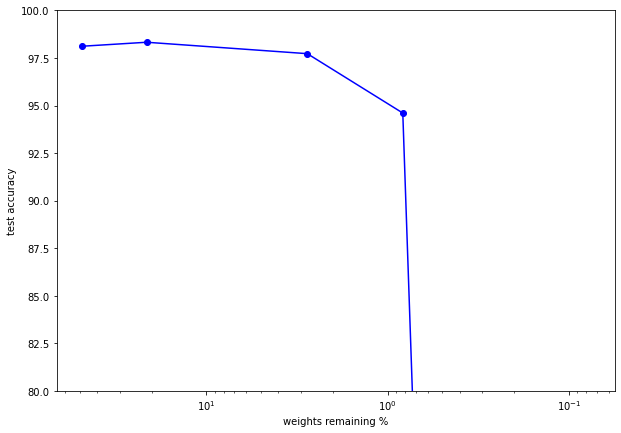

In [26]:
fig = plt.figure(figsize=(10,7))
plt.semilogx(Fracs*100, Stats[:],'-bo')
plt.ylabel('test accuracy')
plt.xlabel('weights remaining %')
plt.ylim([80,100])
plt.gca().invert_xaxis()
plt.show()

# Exercise 8: Compare LF mask with random masking

Then next task is to compare the efficiency of LF mask with respect to random masking. This goes as before, the only difference being how you compute the mask.
You will just have to complete the function
    
    random_training
    
    
When you finish plot the results of the LF mask and the random mask together.

In [27]:
def random_training(model, level, epochs):
    # rewind
    model.load_state_dict(torch.load('models/initial.pt') )
        
    # compute random mask
    mask, frac = random_mask(model, level)

    # apply random mask
    # by setting to zero the weights of the randomly chosen freezed parameters 
    with torch.no_grad():
      for (p, m) in zip(model.parameters(), mask):
        p.mul_(m)
    
    # reinit optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # train
    for epoch in range(1, epochs + 1):
        train(model,device,train_loader,optimizer,epoch,mask=mask)
    acc=test(model, device, test_loader,verbose=True)

    return acc,frac

In [28]:
# we define the levels of pruning here, from 0 to 1
num_levels=10
#pruning_levels = np.linspace(0,1,num_levels)
pruning_levels=[0,0.33,0.66,0.83,0.86,0.89,0.92,0.95,0.98,1]
print(pruning_levels)

[0, 0.33, 0.66, 0.83, 0.86, 0.89, 0.92, 0.95, 0.98, 1]


In [29]:
Stats = []
Fracs = []

for level in tqdm(pruning_levels):  
    stats, fracs = random_training(model, level, epochs)
    Stats.append(stats)
    Fracs.append(fracs)
    print('prunning level',level,'-> frac=',fracs,' accuracy=',stats)
Stats = np.asarray(Stats)
Fracs = np.asarray(Fracs)

np.save('models/Stats_random_mask.npy', Stats)
np.save('models/Fracs_random_mask.npy', Fracs)

 10%|█         | 1/10 [01:59<17:56, 119.56s/it]


Test set: Average loss: 0.0559, Accuracy: 9819/10000 (98.19%)

prunning level 0 -> frac= 1.0  accuracy= 98.19


 20%|██        | 2/10 [04:01<16:01, 120.19s/it]


Test set: Average loss: 0.0640, Accuracy: 9806/10000 (98.06%)

prunning level 0.33 -> frac= 0.669059107358263  accuracy= 98.06


 30%|███       | 3/10 [05:57<13:53, 119.06s/it]


Test set: Average loss: 0.1032, Accuracy: 9681/10000 (96.81%)

prunning level 0.66 -> frac= 0.3387051127400946  accuracy= 96.81


 40%|████      | 4/10 [07:57<11:55, 119.25s/it]


Test set: Average loss: 0.2556, Accuracy: 9273/10000 (92.73%)

prunning level 0.83 -> frac= 0.17068293588197087  accuracy= 92.73


 50%|█████     | 5/10 [09:57<09:58, 119.62s/it]


Test set: Average loss: 0.3766, Accuracy: 8842/10000 (88.42%)

prunning level 0.86 -> frac= 0.14048204509603787  accuracy= 88.42


 60%|██████    | 6/10 [11:59<08:01, 120.27s/it]


Test set: Average loss: 2.2938, Accuracy: 2783/10000 (27.83%)

prunning level 0.89 -> frac= 0.10962698339055396  accuracy= 27.83


 70%|███████   | 7/10 [14:03<06:03, 121.21s/it]


Test set: Average loss: 2.3023, Accuracy: 2292/10000 (22.92%)

prunning level 0.92 -> frac= 0.08024032662150876  accuracy= 22.92


 80%|████████  | 8/10 [16:05<04:03, 121.63s/it]


Test set: Average loss: 2.3024, Accuracy: 1135/10000 (11.35%)

prunning level 0.95 -> frac= 0.05003711608054189  accuracy= 11.35


 90%|█████████ | 9/10 [18:05<02:01, 121.02s/it]


Test set: Average loss: 2.3026, Accuracy: 1660/10000 (16.60%)

prunning level 0.98 -> frac= 0.019655284401967153  accuracy= 16.6


100%|██████████| 10/10 [20:01<00:00, 120.13s/it]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

prunning level 1 -> frac= 0.0  accuracy= 10.09


In [30]:
Stats = np.load('models/Stats_LF_mask.npy')
Fracs = np.load('models/Fracs_LF_mask.npy')
Stats_rand = np.load('models/Stats_random_mask.npy')
Fracs_rand = np.load('models/Fracs_random_mask.npy')

# Plot together

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  import sys


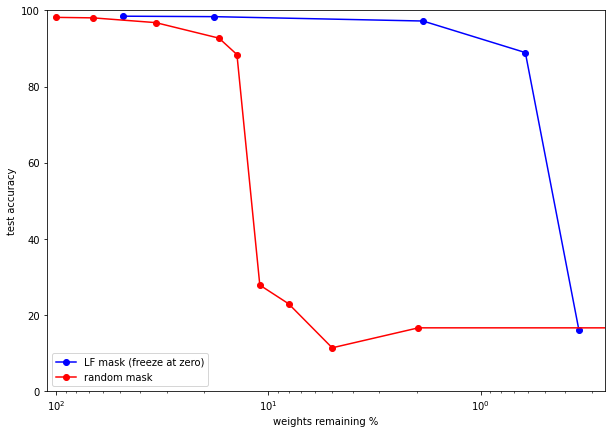

In [31]:
fig = plt.figure(figsize=(10,7))
plt.semilogx(Fracs*100, Stats[:],'-bo',label='LF mask (freeze at zero)')
# we leave out the last point if the frac is 0, in order to avoid the log(0)
plt.semilogx(Fracs_rand[:]*100, Stats_rand[:],'-ro',label='random mask')
plt.ylabel('test accuracy')
plt.xlabel('weights remaining %')
plt.xlim([0, 110])
plt.ylim([0,100])
plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [32]:
Stats_rand
Fracs_rand
ordering=Fracs_rand.argsort()
for i in range(0,len(Stats_rand)):
    print(Fracs_rand[i]*100,Stats_rand[i])
Stats_rand=Stats_rand[ordering]
Fracs_rand=Fracs_rand[ordering]
print('\n')
for i in range(0,len(Stats_rand)):
    print(Fracs_rand[i]*100,Stats_rand[i])

100.0 98.19
66.9059107358263 98.06
33.87051127400946 96.81
17.068293588197086 92.73
14.048204509603787 88.42
10.962698339055397 27.83
8.024032662150876 22.92
5.003711608054189 11.35
1.9655284401967152 16.6
0.0 10.09


0.0 10.09
1.9655284401967152 16.6
5.003711608054189 11.35
8.024032662150876 22.92
10.962698339055397 27.83
14.048204509603787 88.42
17.068293588197086 92.73
33.87051127400946 96.81
66.9059107358263 98.06
100.0 98.19


It should be clear from this plot that 

- if we do random masking, pruning more than $20 \%$ of the parameters severely affect the network performance 
- if we use the mask given by the LF criterion, we can prune much more without affecting the performance sensibly

This means that, for example, we could endow an embedded system - at least in principle - with a tenfold smaller network just by using a very simple masking method.

### THAT'S NOT ALL !!!

# OPTIONAL ASSIGNMENTS

If you want to receive full grades you should work on the following two exercises.

<span style="color:blue">These exercises are just sketched: incomplete but reasonable attempts to solve them will be considered for evaluation. Variations on these themes, inspired by your curiosity (for example in the case of Exercise 1 you could also implement another type of mask, I would suggest in this case the *magnitude increase* mask), will be considered equivalently.</span>


### Exercise 1

Implement the original version of the LF mask (or another one of your choice).
Check that it works for a few values of the pruning level and if you have time/will plot it as a function of pruning level.

In [54]:
def original_LF_mask(model,level):
    '''
    Construct large final (LF) mask. The threshold for 
    decision is determined globally.
    '''
    frac = 0
    tot = 0
    
    # compute the mask : mask=1 if (|p_i| > m + \alpha \times s)
    mask = []
    for i, p in enumerate( model.parameters() ):
        params=p.detach().numpy()
        abs_flat_params=np.abs(params.flatten())
        abs_sorted_params=np.sort(abs_flat_params)
        threshold_index=int(len(abs_sorted_params)*level)
        threshold=abs_sorted_params[threshold_index]
        condition=np.abs(params)>threshold
        numpy_mask=np.zeros(np.shape(condition),dtype=float)
        numpy_mask[condition]=1
        mask.append(torch.from_numpy(numpy_mask))
        
        frac += torch.sum( mask[i] ).item()
        tot += mask[i].numel()

    frac = frac/tot
    
    return mask, frac

In [55]:
def original_LF_level_training(model, level, epochs):
    
    # load final weights and compute mask at level alpha
    model.load_state_dict(torch.load('models/trained_without_mask.pt') )
    with torch.no_grad():
        mask, frac = original_LF_mask(model,level)
        
    # rewind
    model.load_state_dict(torch.load('models/initial.pt') )
        
    # apply mask
    with torch.no_grad():
      for (p, m) in zip(model.parameters(), mask):
        p.mul_(m)
    
    # reinit optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # train
    for epoch in range(1, epochs + 1):
        train(model,device,train_loader,optimizer,epoch,mask=mask)
    acc=test(model, device, test_loader,verbose=True)

    return acc,frac

In [56]:
# we define the levels of pruning here, from 0 to 1
num_levels=10
#pruning_levels = np.linspace(0,1,num_levels)
pruning_levels=[0,0.8,0.95,0.98,0.9825,0.985,0.9875,0.99,0.9925,0.995,0.9975]
print(pruning_levels)
Stats = []
Fracs = []

for level in tqdm(pruning_levels):  
    stats, fracs = original_LF_level_training(model, level, epochs)
    Stats.append(stats)
    Fracs.append(fracs)
    print('prunning level',level,'-> frac=',fracs,' accuracy=',stats)
Stats = np.asarray(Stats)
Fracs = np.asarray(Fracs)

np.save('models/Stats_original_LF_mask.npy', Stats)
np.save('models/Fracs_original_LF_mask.npy', Fracs)

  0%|          | 0/11 [00:00<?, ?it/s]

[0, 0.8, 0.95, 0.98, 0.9825, 0.985, 0.9875, 0.99, 0.9925, 0.995, 0.9975]


  9%|▉         | 1/11 [01:57<19:37, 117.73s/it]


Test set: Average loss: 0.0508, Accuracy: 9843/10000 (98.43%)

prunning level 0 -> frac= 0.999981441959729  accuracy= 98.43


 18%|█▊        | 2/11 [03:58<17:48, 118.75s/it]


Test set: Average loss: 0.0552, Accuracy: 9823/10000 (98.23%)

prunning level 0.8 -> frac= 0.19998144195972906  accuracy= 98.23


 27%|██▋       | 3/11 [06:03<16:04, 120.55s/it]


Test set: Average loss: 0.1107, Accuracy: 9672/10000 (96.72%)

prunning level 0.95 -> frac= 0.049983761714762924  accuracy= 96.72


 36%|███▋      | 4/11 [08:01<13:58, 119.83s/it]


Test set: Average loss: 0.2899, Accuracy: 9129/10000 (91.29%)

prunning level 0.98 -> frac= 0.01998468961677647  accuracy= 91.29


 45%|████▌     | 5/11 [10:07<12:08, 121.48s/it]


Test set: Average loss: 0.3270, Accuracy: 9022/10000 (90.22%)

prunning level 0.9825 -> frac= 0.017488633200334044  accuracy= 90.22


 55%|█████▍    | 6/11 [12:05<10:03, 120.66s/it]


Test set: Average loss: 0.5003, Accuracy: 8445/10000 (84.45%)

prunning level 0.985 -> frac= 0.014987937273823883  accuracy= 84.45


 64%|██████▎   | 7/11 [14:04<07:59, 119.92s/it]


Test set: Average loss: 1.9491, Accuracy: 3269/10000 (32.69%)

prunning level 0.9875 -> frac= 0.012491880857381461  accuracy= 32.69


 73%|███████▎  | 8/11 [16:02<05:58, 119.48s/it]


Test set: Average loss: 2.2998, Accuracy: 1993/10000 (19.93%)

prunning level 0.99 -> frac= 0.009986545420803563  accuracy= 19.93


 82%|████████▏ | 9/11 [18:02<03:59, 119.73s/it]


Test set: Average loss: 2.3021, Accuracy: 1507/10000 (15.07%)

prunning level 0.9925 -> frac= 0.007490489004361139  accuracy= 15.07


 91%|█████████ | 10/11 [20:01<01:59, 119.41s/it]


Test set: Average loss: 2.3025, Accuracy: 1009/10000 (10.09%)

prunning level 0.995 -> frac= 0.004989793077850979  accuracy= 10.09


100%|██████████| 11/11 [22:04<00:00, 120.43s/it]


Test set: Average loss: 2.3026, Accuracy: 826/10000 (8.26%)

prunning level 0.9975 -> frac= 0.0024937366614085554  accuracy= 8.26


/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


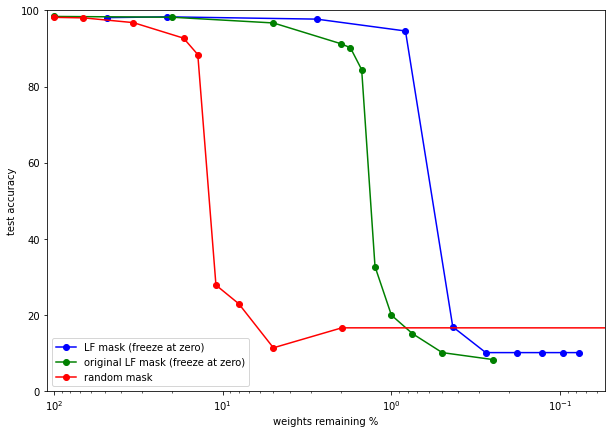

In [57]:
Stats = np.load('models/Stats_LF_mask.npy')
Fracs = np.load('models/Fracs_LF_mask.npy')
Stats_orig = np.load('models/Stats_original_LF_mask.npy')
Fracs_orig = np.load('models/Fracs_original_LF_mask.npy')
Stats_rand = np.load('models/Stats_random_mask.npy')
Fracs_rand = np.load('models/Fracs_random_mask.npy')
fig = plt.figure(figsize=(10,7))
plt.semilogx(Fracs*100, Stats[:],'-bo',label='LF mask (freeze at zero)')
plt.semilogx(Fracs_orig*100, Stats_orig[:],'-go',label='original LF mask (freeze at zero)')
# we leave out the last point if the frac is 0, in order to avoid the log(0)
plt.semilogx(Fracs_rand[:]*100, Stats_rand[:],'-ro',label='random mask')
plt.ylabel('test accuracy')
plt.xlabel('weights remaining %')
plt.xlim([0, 110])
plt.ylim([0,100])
plt.gca().invert_xaxis()
plt.legend()
plt.show()

#### Interpretation of the results
The original LF masks (the one described in the article) performs worst than the one proposed at the beginning of this notebook. 
An explaination seems to be that the original LF acts by masking in every layer the top x% of the weights, so that every layer has the same percentage of frozen weights. This seems to be non-optimal, and using instead the LF mask  proposed at the beginning of this notebook allows to increase the sparsity of the network while maintaining trainable networks.
The reason for that might might that all layers are different and act differently on the data, so that in some layers larger portions of the weights would tend to zero, while in other layers the portion of weights that would have vanished is smaller.

### Exercise 2

Pruning means setting exactly to zero the weigths we want to eliminate.
What if, on the contrary, we keep these weigths frozen at their initialization values? 

In this case notice that we are *not* pruning the network.
In order to do that there is just a very simple thing to do (or not do) in the function alpha_training.
Find it, make this new experiment and plot all the 
three results together (with LF masking, random masking and this version). 

(You can do that with both versions of the LF masking: the original version of the optional Exercise 1 or our version: choose whatever you want).

If you want you could also add a test to see that the freezed parameters 
do not move from their initial values, by constructing a suitable alert function.

In [58]:
def original_LF_level_training(model, level, epochs,pruning=True):
    
    # load final weights and compute mask at level alpha
    model.load_state_dict(torch.load('models/trained_without_mask.pt') )
    with torch.no_grad():
        mask, frac = original_LF_mask(model,level)
        
    # rewind
    model.load_state_dict(torch.load('models/initial.pt') )
    
    if(pruning):
        # apply mask
        with torch.no_grad():
          for (p, m) in zip(model.parameters(), mask):
            p.mul_(m)
    
    # reinit optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # train
    for epoch in range(1, epochs + 1):
        train(model,device,train_loader,optimizer,epoch,mask=mask)
    acc=test(model, device, test_loader,verbose=True)

    return acc,frac

In [59]:
# we define the levels of pruning here, from 0 to 1
num_levels=10
#pruning_levels = np.linspace(0,1,num_levels)
pruning_levels=[0,0.3,0.6,0.8,0.9,0.95,0.98,0.99,0.995,0.999]

print(pruning_levels)
Stats = []
Fracs = []

for level in tqdm(pruning_levels):  
    stats, fracs = original_LF_level_training(model, level, epochs,pruning=False)
    Stats.append(stats)
    Fracs.append(fracs)
    print('prunning level',level,'-> frac=',fracs,' accuracy=',stats)
Stats = np.asarray(Stats)
Fracs = np.asarray(Fracs)

np.save('models/Stats_original_LF_mask_no_pruning.npy', Stats)
np.save('models/Fracs_original_LF_mask_no_pruning.npy', Fracs)

  0%|          | 0/10 [00:00<?, ?it/s]

[0, 0.3, 0.6, 0.8, 0.9, 0.95, 0.98, 0.99, 0.995, 0.999]


 10%|█         | 1/10 [02:16<20:26, 136.23s/it]


Test set: Average loss: 0.0512, Accuracy: 9836/10000 (98.36%)

prunning level 0 -> frac= 0.999981441959729  accuracy= 98.36


 20%|██        | 2/10 [04:20<17:42, 132.78s/it]


Test set: Average loss: 0.0538, Accuracy: 9826/10000 (98.26%)

prunning level 0.3 -> frac= 0.699981441959729  accuracy= 98.26


 30%|███       | 3/10 [06:24<15:10, 130.08s/it]


Test set: Average loss: 0.0651, Accuracy: 9802/10000 (98.02%)

prunning level 0.6 -> frac= 0.39998144195972907  accuracy= 98.02


 40%|████      | 4/10 [08:29<12:50, 128.47s/it]


Test set: Average loss: 0.0784, Accuracy: 9751/10000 (97.51%)

prunning level 0.8 -> frac= 0.19998144195972906  accuracy= 97.51


 50%|█████     | 5/10 [10:33<10:35, 127.16s/it]


Test set: Average loss: 0.0928, Accuracy: 9732/10000 (97.32%)

prunning level 0.9 -> frac= 0.09998144195972905  accuracy= 97.32


 60%|██████    | 6/10 [12:36<08:23, 125.88s/it]


Test set: Average loss: 0.1129, Accuracy: 9655/10000 (96.55%)

prunning level 0.95 -> frac= 0.049983761714762924  accuracy= 96.55


 70%|███████   | 7/10 [14:40<06:16, 125.39s/it]


Test set: Average loss: 0.1554, Accuracy: 9532/10000 (95.32%)

prunning level 0.98 -> frac= 0.01998468961677647  accuracy= 95.32


 80%|████████  | 8/10 [16:43<04:09, 124.75s/it]


Test set: Average loss: 0.2185, Accuracy: 9353/10000 (93.53%)

prunning level 0.99 -> frac= 0.009986545420803563  accuracy= 93.53


 90%|█████████ | 9/10 [18:48<02:04, 124.74s/it]


Test set: Average loss: 0.3162, Accuracy: 9085/10000 (90.85%)

prunning level 0.995 -> frac= 0.004989793077850979  accuracy= 90.85


100%|██████████| 10/10 [20:54<00:00, 125.40s/it]


Test set: Average loss: 1.6166, Accuracy: 5318/10000 (53.18%)

prunning level 0.999 -> frac= 0.0009905353994618168  accuracy= 53.18


In [60]:
def alpha_training(model, alpha, epochs,pruning=True):
    
    # load final weights and compute mask at level alpha
    model.load_state_dict(torch.load('models/trained_without_mask.pt') )
    with torch.no_grad():
        mask, frac = LF_mask(model,alpha)
        
    # rewind
    model.load_state_dict(torch.load('models/initial.pt') )
        
    if(pruning):
        # apply mask
        with torch.no_grad():
          for (p, m) in zip(model.parameters(), mask):
            p.mul_(m)
    
    # reinit optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # train
    for epoch in range(1, epochs + 1):
        train(model,device,train_loader,optimizer,epoch,mask=mask)
    acc=test(model, device, test_loader,verbose=True)

    return acc,frac

In [61]:
num_levels=10
alphas = np.linspace(0,4,num_levels)
Stats = []
Fracs = []
for alpha in tqdm(alphas):  
    stats, fracs = alpha_training(model, alpha, epochs,pruning=False)
    Stats.append(stats)
    Fracs.append(fracs)
    print('alpha=',alpha,'frac=',fracs,'(prunning level',fracs-1,') accuracy=',stats)
Stats = np.asarray(Stats)
Fracs = np.asarray(Fracs)
np.save('models/Stats_LF_mask_no_pruning.npy', Stats)
np.save('models/Fracs_LF_mask_no_pruning.npy', Fracs)

  0%|          | 0/10 [00:00<?, ?it/s]

m= 0.01862640913122882 s= 0.02236664366658288


 10%|█         | 1/10 [02:04<18:38, 124.28s/it]


Test set: Average loss: 0.0720, Accuracy: 9767/10000 (97.67%)

alpha= 0.0 frac= 0.4847754477127215 (prunning level -0.5152245522872785 ) accuracy= 97.67
m= 0.01862640913122882 s= 0.02236664366658288


 20%|██        | 2/10 [04:08<16:33, 124.19s/it]


Test set: Average loss: 0.0658, Accuracy: 9804/10000 (98.04%)

alpha= 0.4444444444444444 frac= 0.21309733692122113 (prunning level -0.7869026630787789 ) accuracy= 98.04
m= 0.01862640913122882 s= 0.02236664366658288


 30%|███       | 3/10 [06:12<14:28, 124.12s/it]


Test set: Average loss: 0.0866, Accuracy: 9738/10000 (97.38%)

alpha= 0.8888888888888888 frac= 0.027711793634592186 (prunning level -0.9722882063654078 ) accuracy= 97.38
m= 0.01862640913122882 s= 0.02236664366658288


 40%|████      | 4/10 [08:28<12:46, 127.69s/it]


Test set: Average loss: 0.1276, Accuracy: 9604/10000 (96.04%)

alpha= 1.3333333333333333 frac= 0.008242089635334508 (prunning level -0.9917579103646655 ) accuracy= 96.04
m= 0.01862640913122882 s= 0.02236664366658288


 50%|█████     | 5/10 [10:49<10:59, 131.81s/it]


Test set: Average loss: 0.1654, Accuracy: 9508/10000 (95.08%)

alpha= 1.7777777777777777 frac= 0.004319383873063004 (prunning level -0.995680616126937 ) accuracy= 95.08
m= 0.01862640913122882 s= 0.02236664366658288


 60%|██████    | 6/10 [13:30<09:21, 140.42s/it]


Test set: Average loss: 0.2058, Accuracy: 9356/10000 (93.56%)

alpha= 2.2222222222222223 frac= 0.0027535492252018187 (prunning level -0.9972464507747982 ) accuracy= 93.56
m= 0.01862640913122882 s= 0.02236664366658288


 70%|███████   | 7/10 [15:57<07:07, 142.55s/it]


Test set: Average loss: 0.2636, Accuracy: 9161/10000 (91.61%)

alpha= 2.6666666666666665 frac= 0.0017885311311125545 (prunning level -0.9982114688688875 ) accuracy= 91.61
m= 0.01862640913122882 s= 0.02236664366658288


 80%|████████  | 8/10 [18:36<04:54, 147.42s/it]


Test set: Average loss: 0.4077, Accuracy: 8687/10000 (86.87%)

alpha= 3.1111111111111107 frac= 0.0012828245337292382 (prunning level -0.9987171754662708 ) accuracy= 86.87
m= 0.01862640913122882 s= 0.02236664366658288


 90%|█████████ | 9/10 [21:04<02:27, 147.48s/it]


Test set: Average loss: 0.6530, Accuracy: 7968/10000 (79.68%)

alpha= 3.5555555555555554 frac= 0.0009650180940892642 (prunning level -0.9990349819059108 ) accuracy= 79.68
m= 0.01862640913122882 s= 0.02236664366658288


100%|██████████| 10/10 [23:29<00:00, 140.97s/it]


Test set: Average loss: 1.4822, Accuracy: 5140/10000 (51.40%)

alpha= 4.0 frac= 0.000772478426278185 (prunning level -0.9992275215737219 ) accuracy= 51.4


/usr/lib/python3/dist-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


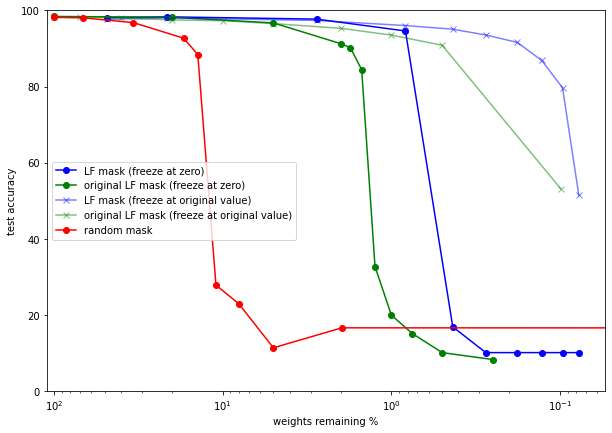

In [62]:
Stats = np.load('models/Stats_LF_mask.npy')
Fracs = np.load('models/Fracs_LF_mask.npy')
Stats_orig = np.load('models/Stats_original_LF_mask.npy')
Fracs_orig = np.load('models/Fracs_original_LF_mask.npy')
Stats_rand = np.load('models/Stats_random_mask.npy')
Fracs_rand = np.load('models/Fracs_random_mask.npy')
Stats_NP = np.load('models/Stats_LF_mask_no_pruning.npy')
Fracs_NP = np.load('models/Fracs_LF_mask_no_pruning.npy')
Stats_orig_NP = np.load('models/Stats_original_LF_mask_no_pruning.npy')
Fracs_orig_NP = np.load('models/Fracs_original_LF_mask_no_pruning.npy')
fig = plt.figure(figsize=(10,7))
plt.semilogx(Fracs*100, Stats[:],'-bo',label='LF mask (freeze at zero)')
plt.semilogx(Fracs_orig*100, Stats_orig[:],'-go',label='original LF mask (freeze at zero)')
plt.semilogx(Fracs_NP*100, Stats_NP[:],'-bx',alpha=0.5,label='LF mask (freeze at original value)')
plt.semilogx(Fracs_orig_NP*100, Stats_orig_NP[:],'-gx',alpha=0.5,label='original LF mask (freeze at original value)')
# we leave out the last point if the frac is 0, in order to avoid the log(0)
plt.semilogx(Fracs_rand[:]*100, Stats_rand[:],'-ro',label='random mask')
plt.ylabel('test accuracy')
plt.xlabel('weights remaining %')
plt.xlim([0, 110])
plt.ylim([0,100])
plt.gca().invert_xaxis()
plt.legend()
plt.show()

#### Interpretation of the results
Here we can see that freezing the masks but maintaining the weights to their original values allows to maintain trainable networks for a higher number of frozen weights.
This approach allows to create sparser networks respect to the prunned approach ; however the advantage of such an approach must be evaluated because the gain in memory or computational time needs to be measured. In fact, the non-null frozen weights must need to be considered in some way, which might eventually require some additional computational time or memory respect to the prunned network. Comparisons of the consumption of the two kind of networks must be necessary before beeing able to draw any conclusion. 


![](./figs_nb/Thats_all_folks.svg)
